In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0004, 500]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

centred_moments = np.zeros((78,5))
centred_moments[:,0] = centred_moment_1
centred_moments[:,1] = centred_moment_2
centred_moments[:,2] = centred_moment_3
centred_moments[:,3] = centred_moment_4
centred_moments[:,4] = centred_moment_5

# print(centred_moments.shape)


Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 10


Set-up pints problem and log likelihoods

In [4]:

problem = pints.MultiOutputProblem(model, times, centred_moments)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [13]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.0001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 10000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 10
prior_arr_lower[3] = 0
prior_arr_upper[3] = 20
prior_arr_lower[4] = 0
prior_arr_upper[4] = 2000
prior_arr_lower[5] = 0
prior_arr_upper[5] = 20000
prior_arr_lower[6] = 0
prior_arr_upper[6] = 400000


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_19988/2681954454.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [14]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs,method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     477     0:01.1
2     921     0:02.1
3     1371    0:03.2
20    8742    0:22.0
40    16992   0:43.5
60    27981   1:13.7
80    41679   1:48.2
100   58308   2:24.9
120   77475   3:04.1
140   97902   3:45.1
160   120915   4:29.6
180   147051   5:19.5
200   176622   6:15.9
220   207774   7:12.7
240   241446   8:13.9
260   276930   9:18.2
280   315450  10:28.0
300   356592  11:41.4
320   398943  12:54.8
340   444051  14:15.5
360   491133  15:37.3
380   540621  17:03.0
400   592509  18:34.4
420   644328  20:07.1
440   695781  21:38.4
460   747810  23:11.6
480   799527  24:43.0
500   850920  26:16.4
520   902745  27:48.5
540   954450  29:18.8
560   1005780  30:50.1
580   1057488  32:20.4
600   1109436  33:47.1
620   1161042  35:14.0
640   1212615  36:42.4
660   1263762  38:08.3
680   1314759  39:34.8
700   1365936  41:01.9
720   1417353  42:29.4
740   1469142  43:57

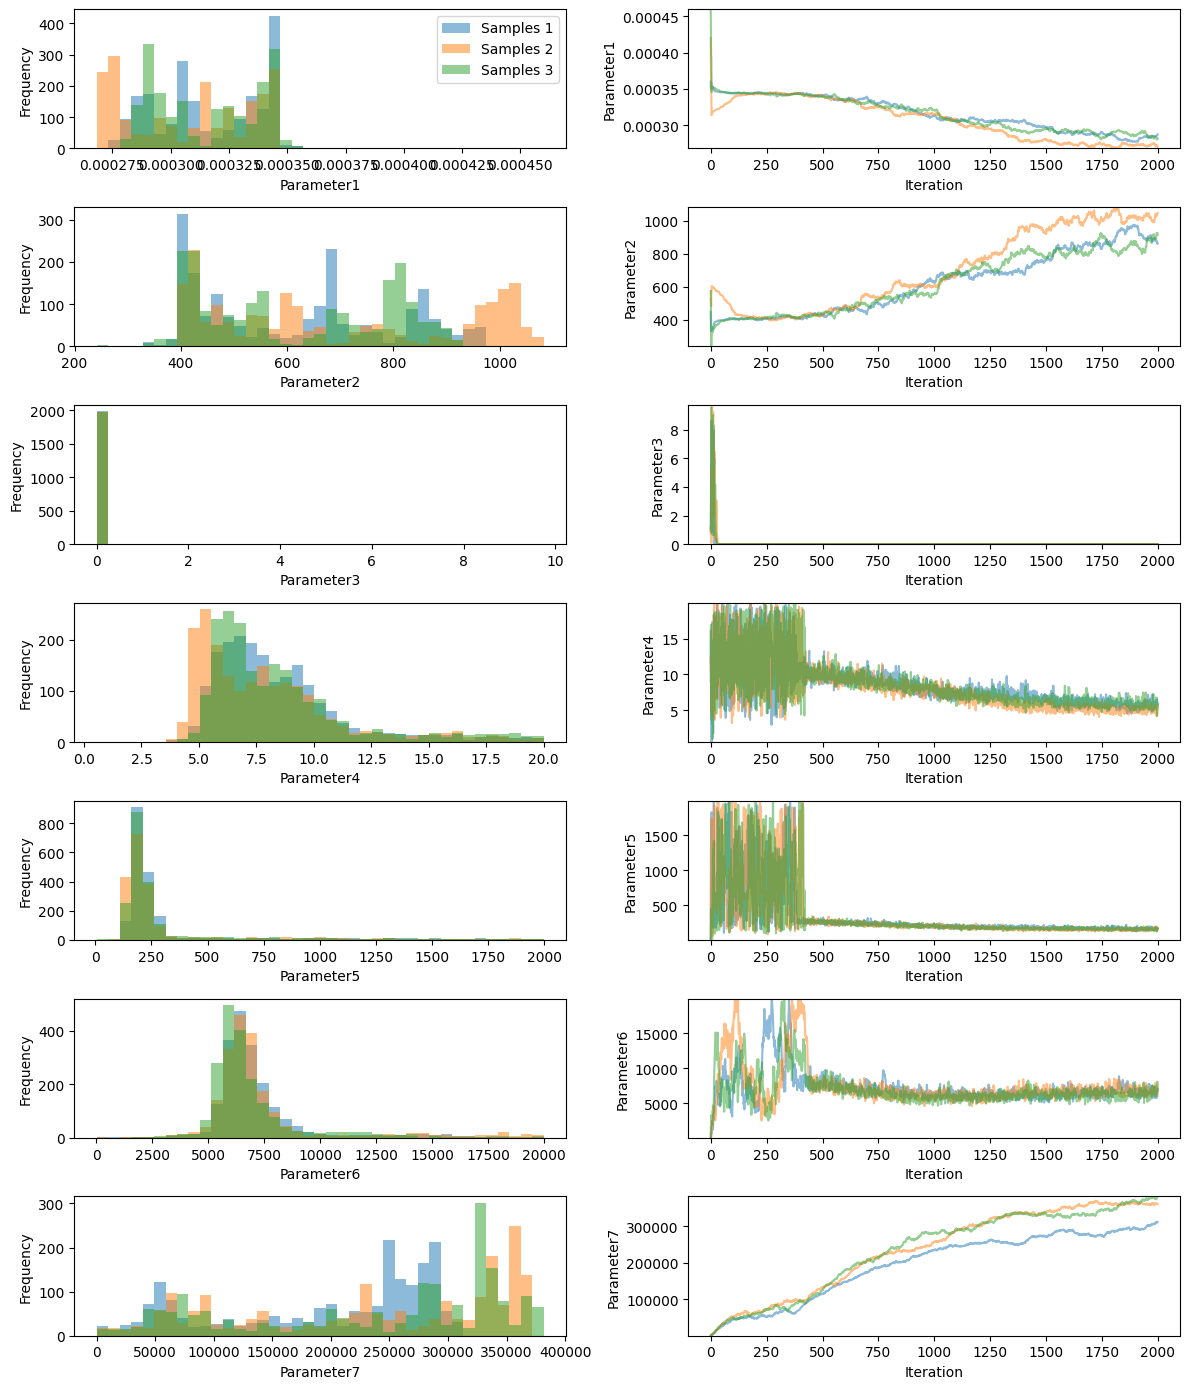

In [15]:

pints.plot.trace(chains)
plt.savefig("mcmc.png")
plt.show()


In [36]:

# ITERS = 100
AllChains = chains[0,:-int(3*ITERS/4),:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(500, 7)
[3.60e-04 4.50e+02 9.00e-01 9.00e+00 2.25e+01 2.25e+01 2.25e+01]
[[3.60000000e-004 4.50000000e+002 9.00000000e-001 ... 2.25000000e+001
  2.25000000e+001 2.25000000e+001]
 [3.50668446e-004 3.36637267e+002 3.35113236e+000 ... 7.05038921e+002
  1.56170918e+002 8.27196961e+002]
 [3.50759247e-004 3.45434089e+002 5.12925558e+000 ... 1.70456171e+003
  2.45269298e+002 9.86043125e+002]
 ...
 [3.40615919e-004 4.34483477e+002 1.57200888e-162 ... 2.62321042e+002
  9.47004616e+003 1.13665114e+005]
 [3.40803535e-004 4.27418480e+002 1.58446676e-162 ... 2.75258183e+002
  9.30432242e+003 1.14437705e+005]
 [3.41454468e-004 4.28530337e+002 1.60617828e-162 ... 2.89568142e+002
  9.06415401e+003 1.14247591e+005]]


In [46]:

for I in range(3-1):
    AllChains_add = chains[I+1,:-int(2*ITERS/4),:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


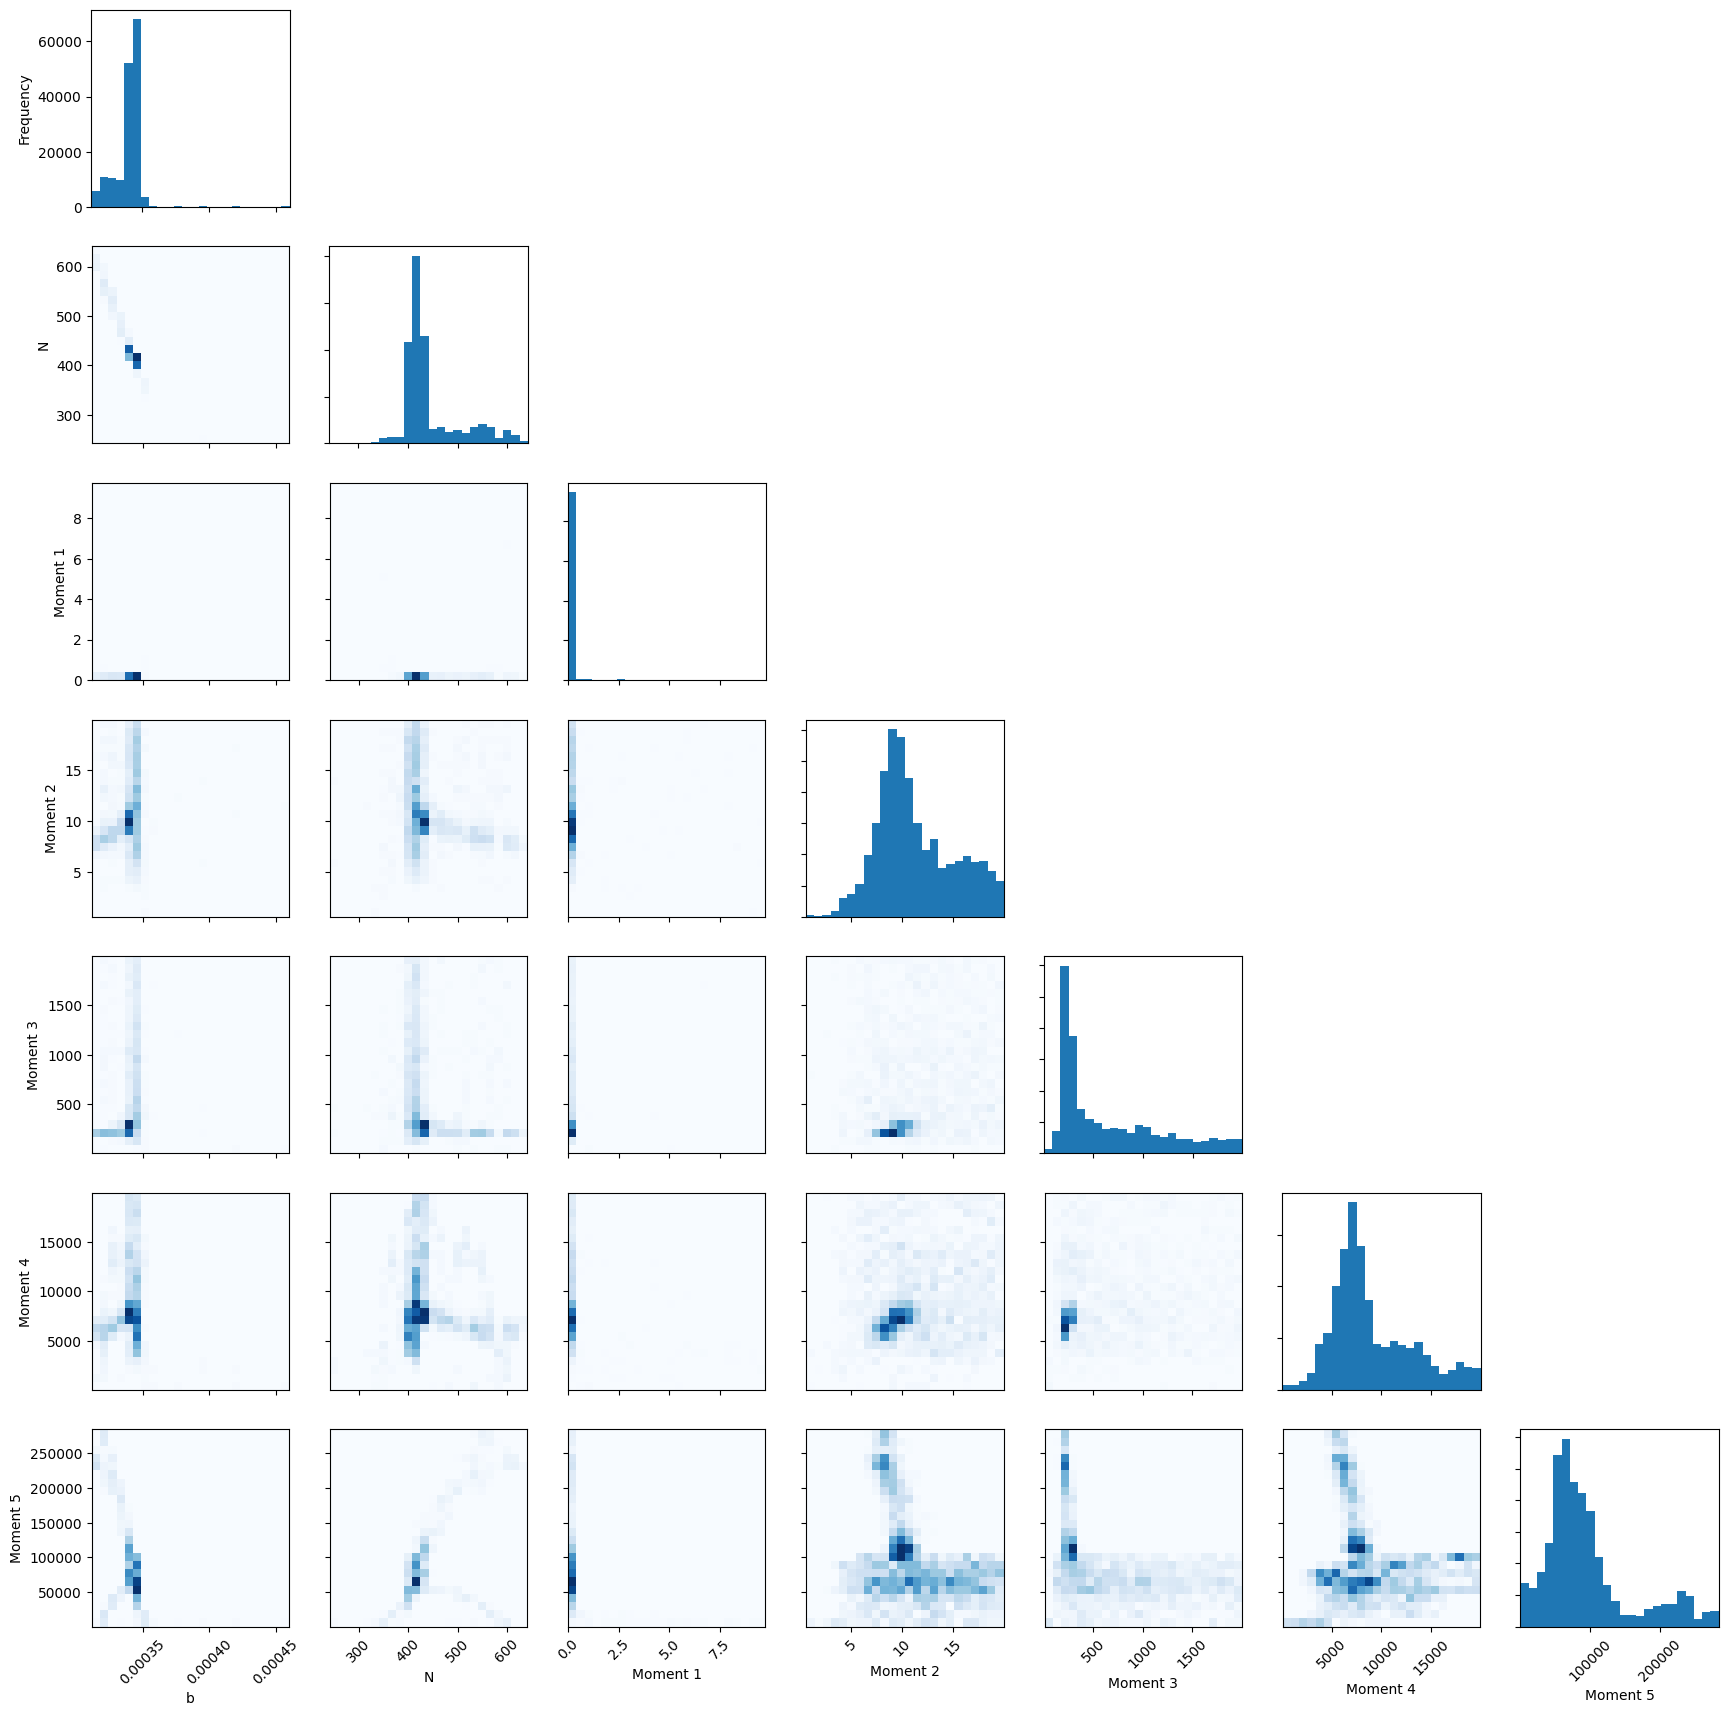

In [47]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()